# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 7

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter7()
# This is needed to render the plots in this chapter
from plots.chapter7 import *

Finished!


In [3]:
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, ToPILImage, CenterCrop, RandomResizedCrop
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, resnet18, inception_v3

# Updated for Torchvision 0.15
from torchvision.models.alexnet import AlexNet_Weights
from torchvision.models.inception import Inception_V3_Weights
from torchvision.models.resnet import ResNet18_Weights
# from torchvision.models.alexnet import model_urls

try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.hub import load_state_dict_from_url

from stepbystep.v3 import StepByStep
from data_generation.rps import download_rps

# ImageNet Large Scale Visual Recognition Challenge (ILSVRC)

## Comparing Architectures

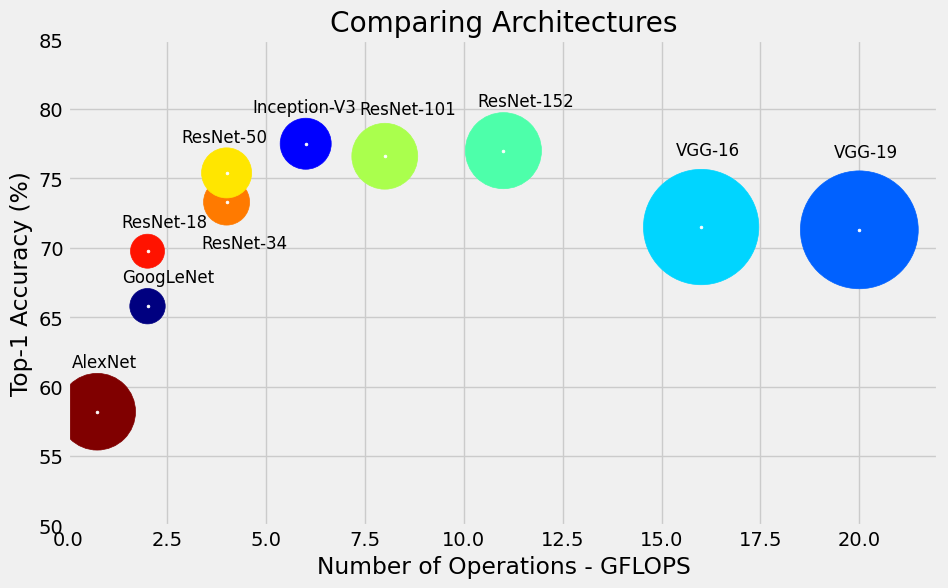

In [4]:
fig = figure1()

*Source: Data for accuracy and GFLOPs estimates obtained from [this](https://github.com/albanie/convnet-burden) report, number of parameters proportional to the size of the circles) obtained from Torchvision’s models. For a more detailed analysis, see Canziani, A., Culurciello, E., Paszke, A. ["An Analysis of Deep Neural Network Models for Practical Applications"](https://arxiv.org/pdf/1605.07678.pdf)(2017).*

# Transfer Learning in Practice

## Pre-Trained Model

The `pretrained` argument of Torchvision models is being deprecated. Instead, you should use the `weights` argument.

To load a model without its weights, you can simply set the argument to `None`.

```python
alex = alexnet(weights=None)
```

To actually load the weights of a pretrained model, you will need to, first, import the corresponding `Weights` object, for example:
```python
from torchvision.models.alexnet import AlexNet_Weights
```

Each `Weights` object has one or more sets of weights (for different versions), but you can also use the (current, since it may change) `DEFAULT` version for loading the pretrained model:
```python
alex = alexnet(weights=AlexNet_Weights.DEFAULT)
```

The code above is the recommended way of loading pretrained models.

But, for the sake of completion, in the code cells that follow I will still illustrate how to retrieve the URL pointing to the weights, and an alternative way of loading the state dictionary directly.

In [5]:
# UPDATED
###########################################################
# Setting weights to None loads an untrained model
alex = alexnet(weights=None)
# alex = alexnet(pretrained=False)
###########################################################

print(alex)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Adaptive Pooling

In [6]:
result1 = F.adaptive_avg_pool2d(torch.randn(16, 32, 32), output_size=(6, 6))
result2 = F.adaptive_avg_pool2d(torch.randn(16, 12, 12), output_size=(6, 6))
result1.shape, result2.shape

(torch.Size([16, 6, 6]), torch.Size([16, 6, 6]))

### Loading Weights

In [84]:
# repeating import from the top for reference
from torchvision.models.alexnet import AlexNet_Weights

# UPDATED
###########################################################
# This is the recommended way of loading a pretrained
# model's weights
weights = AlexNet_Weights.DEFAULT
alex = alexnet(weights=AlexNet_Weights.DEFAULT)
###########################################################

In [8]:
# Before, you could get the URL like this
# url = model_urls['alexnet']

# In Torchvision 0.15, the WEIGHTS object contains the URL
url = weights.url
url

'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth'

In [9]:
# You may still load the state dict from the URL if you want...
state_dict = load_state_dict_from_url(url, model_dir='./pretrained', progress=True)

# But, in Torchvision 0.15, you can use the WEIGHTS object to load the state dict
# state_dict = weights.get_state_dict(progress=True)

In [10]:
# If you have the state dict, you can load it into the empty model
alex = alexnet(weights=None)
alex.load_state_dict(state_dict)

<All keys matched successfully>

### Model Freezing

In [11]:
def freeze_model(model):
    for parameter in model.parameters():
        parameter.requires_grad = False

In [12]:
freeze_model(alex)

### Top of the Model

In [13]:
print(alex.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [14]:
torch.manual_seed(11)
alex.classifier[6] = nn.Linear(4096, 3)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/alexnet.png?raw=1)

*Source: Generated using Alexander Lenail’s [NN-SVG](http://alexlenail.me/NN-SVG/) and adapted by the author*

In [15]:
for name, param in alex.named_parameters():
    if param.requires_grad == True:
        print(name)

classifier.6.weight
classifier.6.bias


## Model Configuration

In [16]:
torch.manual_seed(17)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_alex = optim.Adam(alex.parameters(), lr=3e-4)

## Data Preparation

### Rock Paper Scissors Dataset

>This dataset was created by Laurence Moroney (lmoroney@gmail.com / [laurencemoroney.com](http://www.laurencemoroney.com)) and can be found in his site: [Rock Paper Scissors Dataset](http://www.laurencemoroney.com/rock-paper-scissors-dataset/). 

>The dataset is licensed as Creative Commons (CC BY 2.0). No changes were made to the dataset.

In [ ]:
# This may take a couple of minutes...
download_rps() # if you ran it in Chapter 6, it won't do anything else

In [18]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])

composer = Compose([Resize(256),
                    CenterCrop(224),
                    ToTensor(),
                    normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

## Model Training

In [19]:
sbs_alex = StepByStep(alex, multi_loss_fn, optimizer_alex)
sbs_alex.set_loaders(train_loader, val_loader)
sbs_alex.train(1)

In [20]:
StepByStep.loader_apply(val_loader, sbs_alex.correct)

tensor([[110, 124],
        [124, 124],
        [124, 124]])

## Generating a Dataset of Features

In [21]:
alex.classifier[6] = nn.Identity()
print(alex.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Identity()
)


In [22]:
def preprocessed_dataset(model, loader, device=None):
    if device is None:
        device = next(model.parameters()).device
    
    features = None
    labels = None

    for i, (x, y) in enumerate(loader):
        model.eval()
        x = x.to(device)
        output = model(x)
        if i == 0:
            features = output.detach().cpu()
            labels = y.cpu()
        else:
            features = torch.cat([features, output.detach().cpu()])
            labels = torch.cat([labels, y.cpu()])

    dataset = TensorDataset(features, labels)
    return dataset

In [23]:
train_preproc = preprocessed_dataset(alex, train_loader)
val_preproc = preprocessed_dataset(alex, val_loader)

In [24]:
torch.save(train_preproc.tensors, 'rps_preproc.pth')
torch.save(val_preproc.tensors, 'rps_val_preproc.pth')

In [25]:
x, y = torch.load('rps_preproc.pth')
train_preproc = TensorDataset(x, y)
val_preproc = TensorDataset(*torch.load('rps_val_preproc.pth'))

In [26]:
train_preproc_loader = DataLoader(train_preproc, batch_size=16, shuffle=True)
val_preproc_loader = DataLoader(val_preproc, batch_size=16)

## Top Model

In [27]:
torch.manual_seed(17)
top_model = nn.Sequential(nn.Linear(4096, 3))
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_top = optim.Adam(top_model.parameters(), lr=3e-4)

In [28]:
sbs_top = StepByStep(top_model, multi_loss_fn, optimizer_top)
sbs_top.set_loaders(train_preproc_loader, val_preproc_loader)
sbs_top.train(10)

In [29]:
sbs_alex.model.classifier[6] = top_model
print(sbs_alex.model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=3, bias=True)
  )
)


In [30]:
StepByStep.loader_apply(val_loader, sbs_alex.correct)

tensor([[109, 124],
        [124, 124],
        [124, 124]])

# Auxiliary Classifiers (Side-Heads)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/inception_model.png?raw=1)

In [31]:
# repeating import from the top for reference
from torchvision.models.inception import Inception_V3_Weights

# UPDATED
###########################################################
# This is the recommended way of loading a pretrained
# model's weights
model = inception_v3(weights=Inception_V3_Weights.DEFAULT)
# model = inception_v3(pretrained=True)
###########################################################

freeze_model(model)

torch.manual_seed(42)
model.AuxLogits.fc = nn.Linear(768, 3)
model.fc = nn.Linear(2048, 3)

In [32]:
def inception_loss(outputs, labels):
    try:
        main, aux = outputs
    except ValueError:
        main = outputs
        aux = None
        loss_aux = 0
        
    multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
    loss_main = multi_loss_fn(main, labels)
    if aux is not None:
        loss_aux = multi_loss_fn(aux, labels)
    return loss_main + 0.4 * loss_aux

In [33]:
optimizer_model = optim.Adam(model.parameters(), lr=3e-4)
sbs_incep = StepByStep(model, inception_loss, optimizer_model)

In [34]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])

composer = Compose([Resize(299),
                    ToTensor(),
                    normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

In [35]:
sbs_incep.set_loaders(train_loader, val_loader)
sbs_incep.train(1)

In [36]:
StepByStep.loader_apply(val_loader, sbs_incep.correct)

tensor([[105, 124],
        [ 77, 124],
        [117, 124]])

# 1x1 Convolutions

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/1conv1.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/1conv2.png?raw=1)

$$
\Large
\begin{array}
&\text{Filter 1}: -&1& \text{R} &+& 2& \text{G} &+& 0& \text{B}
\\
\text{Filter 2}: &2& \text{R} &+& 0& \text{G} &-& 2& \text{B}
\end{array}
$$

In [37]:
scissors = Image.open('rps/scissors/scissors01-001.png')
image = ToTensor()(scissors)[:3, :, :].view(1, 3, 300, 300)

weights = torch.tensor([0.2126, 0.7152, 0.0722]).view(1, 3, 1, 1)
convolved = F.conv2d(input=image, weight=weights)

converted = ToPILImage()(convolved[0])
grayscale = scissors.convert('L')

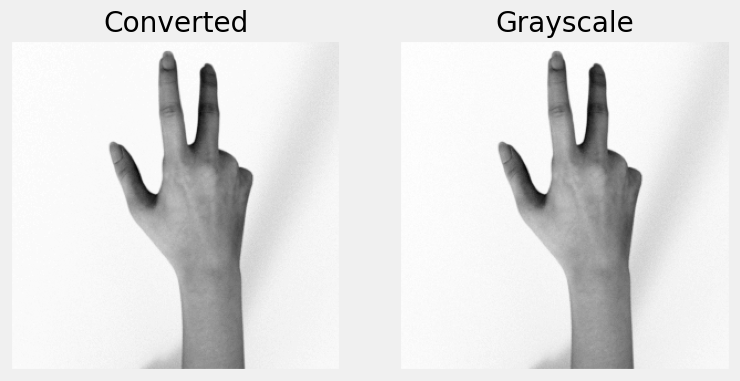

In [38]:
fig = compare_grayscale(converted, grayscale)

# Inception Modules

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/inception_modules.png?raw=1)

In [39]:
class Inception(nn.Module):
    def __init__(self, in_channels):
        super(Inception, self).__init__()
        # in_channels@HxW -> 2@HxW
        self.branch1x1_1 = nn.Conv2d(in_channels, 2, kernel_size=1)

        # in_channels@HxW -> 2@HxW -> 3@HxW
        self.branch5x5_1 = nn.Conv2d(in_channels, 2, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(2, 3, kernel_size=5, padding=2)

        # in_channels@HxW -> 2@HxW -> 3@HxW
        self.branch3x3_1 = nn.Conv2d(in_channels, 2, kernel_size=1)
        self.branch3x3_2 = nn.Conv2d(2, 3, kernel_size=3, padding=1)

        # in_channels@HxW -> in_channels@HxW -> 1@HxW
        self.branch_pool_1 = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        self.branch_pool_2 = nn.Conv2d(in_channels, 2, kernel_size=1)

    def forward(self, x):
        # Produces 2 channels
        branch1x1 = self.branch1x1_1(x)
        # Produces 3 channels
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
        # Produces 3 channels
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        # Produces 2 channels
        branch_pool = self.branch_pool_1(x)
        branch_pool = self.branch_pool_2(branch_pool)
        # Concatenates all channels together (10)
        outputs = torch.cat([branch1x1, branch5x5, branch3x3, branch_pool], 1)
        return outputs        

In [40]:
inception = Inception(in_channels=3)
output = inception(image)
output.shape

torch.Size([1, 10, 300, 300])

In [41]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

# Batch Normalization

$$
\Large
\overline{X} = \frac{1}{n}\sum_{i=1}^n{x_i}
\\
\Large
\sigma(X) = \sqrt{\frac{1}{n}\sum_{i=1}^n{(x_i - \overline{X})^2}}
$$

$$
\Large
\text{standardized }x_i = \frac{x_i-\overline{X}}{\sigma(X)+ \epsilon}
$$

$$
\Large
\text{batch normed }x_i = b + w \text{ standardized }x_i
$$

$$
\Large
\text{batch normed }x_i = \text{standardized }x_i\ \gamma + \beta
$$

## Running Statistics

In [42]:
torch.manual_seed(23)
dummy_points = torch.randn((200, 2)) + torch.rand((200, 2)) * 2
dummy_labels = torch.randint(2, (200, 1))
dummy_dataset = TensorDataset(dummy_points, dummy_labels)
dummy_loader = DataLoader(dummy_dataset, batch_size=64, shuffle=True)

In [43]:
iterator = iter(dummy_loader)
batch1 = next(iterator)
batch2 = next(iterator)
batch3 = next(iterator)

In [44]:
mean1, var1 = batch1[0].mean(axis=0), batch1[0].var(axis=0)
mean1, var1

(tensor([0.9850, 1.0381]), tensor([1.4802, 1.1832]))

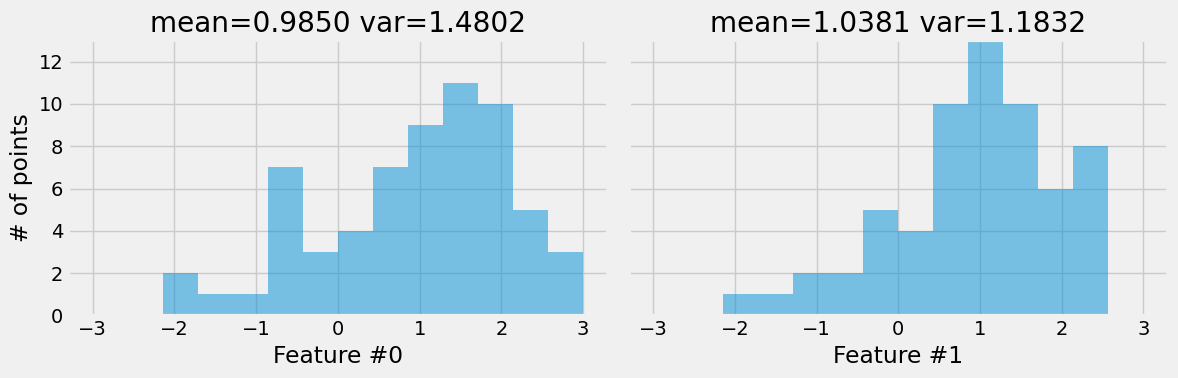

In [45]:
fig = before_batchnorm(batch1)

In [46]:
batch_normalizer = nn.BatchNorm1d(num_features=2, affine=False, momentum=None)
batch_normalizer.state_dict()

OrderedDict([('running_mean', tensor([0., 0.])),
             ('running_var', tensor([1., 1.])),
             ('num_batches_tracked', tensor(0))])

In [47]:
normed1 = batch_normalizer(batch1[0])
batch_normalizer.state_dict()

OrderedDict([('running_mean', tensor([0.9850, 1.0381])),
             ('running_var', tensor([1.4802, 1.1832])),
             ('num_batches_tracked', tensor(1))])

In [48]:
normed1.mean(axis=0), normed1.var(axis=0)

(tensor([6.7055e-08, 1.4435e-07]), tensor([1.0159, 1.0159]))

$$
\Large
\begin{aligned}
\text{Biased Var}(X) &= \frac{1}{n} &\sum_{i=1}^n{(x_i - \overline{X})^2}
\\
\text{Var}(X) &= \frac{1}{n-1} &\sum_{i=1}^n{(x_i - \overline{X})^2}
\end{aligned}
$$

In [49]:
normed1.var(axis=0, unbiased=False)

tensor([1.0000, 1.0000])

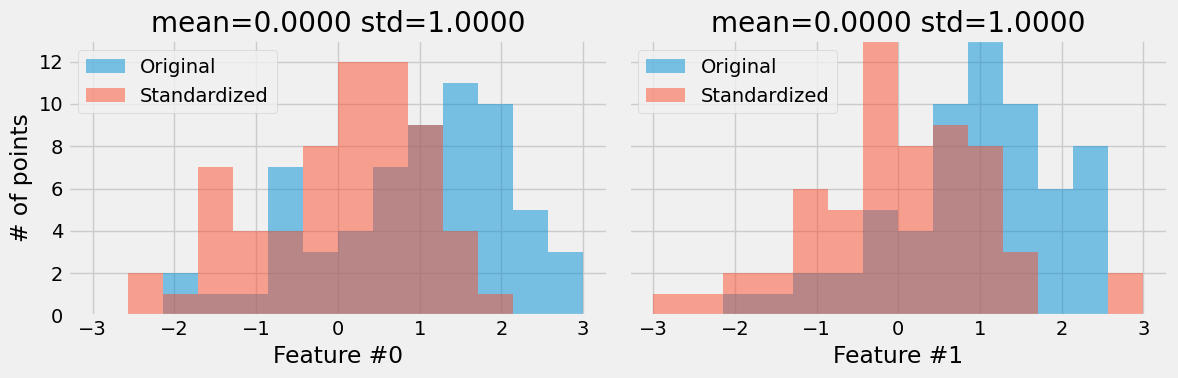

In [50]:
fig = after_batchnorm(batch1, normed1)

In [51]:
normed2 = batch_normalizer(batch2[0])
batch_normalizer.state_dict()

OrderedDict([('running_mean', tensor([0.9611, 0.9964])),
             ('running_var', tensor([1.4247, 1.0460])),
             ('num_batches_tracked', tensor(2))])

In [52]:
mean2, var2 = batch2[0].mean(axis=0), batch2[0].var(axis=0)
running_mean, running_var = (mean1 + mean2) / 2, (var1 + var2) / 2
running_mean, running_var

(tensor([0.9611, 0.9964]), tensor([1.4247, 1.0460]))

## Evaluation Phase

In [53]:
batch_normalizer.eval()
normed3 = batch_normalizer(batch3[0])
normed3.mean(axis=0), normed3.var(axis=0, unbiased=False)

(tensor([-0.0201,  0.2208]), tensor([0.7170, 1.0761]))

## Momentum

$$
\large
\begin{array}
& \text{EWMA}_t(\alpha, x) &= &\alpha &x_t &+ &(1-\alpha) &\text{EWMA}_{t-1}(\alpha, x)
\\
\text{running stat}_t &= &\text{"momentum"} &\text{stat}_t &+ &(1-\text{"momentum"}) &\text{running stat}_{t-1}
\end{array}
$$

In [54]:
batch_normalizer_mom = nn.BatchNorm1d(num_features=2, affine=False, momentum=0.1)
batch_normalizer_mom.state_dict()

OrderedDict([('running_mean', tensor([0., 0.])),
             ('running_var', tensor([1., 1.])),
             ('num_batches_tracked', tensor(0))])

In [55]:
normed1_mom = batch_normalizer_mom(batch1[0])
batch_normalizer_mom.state_dict()

OrderedDict([('running_mean', tensor([0.0985, 0.1038])),
             ('running_var', tensor([1.0480, 1.0183])),
             ('num_batches_tracked', tensor(1))])

In [56]:
running_mean = torch.zeros((1, 2))
running_mean = 0.1 * batch1[0].mean(axis=0) + (1 - 0.1) * running_mean
running_mean

tensor([[0.0985, 0.1038]])

## BatchNorm2d

In [57]:
torch.manual_seed(39)
dummy_images = torch.rand((200, 3, 10, 10))
dummy_labels = torch.randint(2, (200, 1))
dummy_dataset = TensorDataset(dummy_images, dummy_labels)
dummy_loader = DataLoader(dummy_dataset, batch_size=64, shuffle=True)

iterator = iter(dummy_loader)
batch1 = next(iterator)
batch1[0].shape

torch.Size([64, 3, 10, 10])

In [58]:
batch_normalizer = nn.BatchNorm2d(num_features=3, affine=False, momentum=None)
normed1 = batch_normalizer(batch1[0])
normed1.mean(axis=[0, 2, 3]), normed1.var(axis=[0, 2, 3], unbiased=False)

(tensor([ 2.3283e-08, -2.3693e-08,  8.8960e-08]),
 tensor([0.9999, 0.9999, 0.9999]))

# Residual Connections

## Learning the Identity

In [59]:
torch.manual_seed(23)
dummy_points = torch.randn((100, 1))
dummy_dataset = TensorDataset(dummy_points, dummy_points)
dummy_loader = DataLoader(dummy_dataset, batch_size=16, shuffle=True)

In [60]:
class Dummy(nn.Module):
    def __init__(self):
        super(Dummy, self).__init__()
        self.linear = nn.Linear(1, 1)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        out = self.linear(x)
        out = self.activation(out)
        return out

In [61]:
torch.manual_seed(555)
dummy_model = Dummy()
dummy_loss_fn = nn.MSELoss()
dummy_optimizer = optim.SGD(dummy_model.parameters(), lr=0.1)

In [62]:
dummy_sbs = StepByStep(dummy_model, dummy_loss_fn, dummy_optimizer)
dummy_sbs.set_loaders(dummy_loader)
dummy_sbs.train(200)

In [63]:
np.concatenate([dummy_points[:5].numpy(), 
                dummy_sbs.predict(dummy_points)[:5]], axis=1)

array([[-0.9012059 ,  0.        ],
       [ 0.56559485,  0.56559485],
       [-0.48822638,  0.        ],
       [ 0.75069577,  0.75069577],
       [ 0.58925384,  0.58925384]], dtype=float32)

In [64]:
class DummyResidual(nn.Module):
    def __init__(self):
        super(DummyResidual, self).__init__()
        self.linear = nn.Linear(1, 1)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        identity = x
        out = self.linear(x)
        out = self.activation(out)
        out = out + identity
        return out

In [65]:
torch.manual_seed(555)
dummy_model = DummyResidual()
dummy_loss_fn = nn.MSELoss()
dummy_optimizer = optim.SGD(dummy_model.parameters(), lr=0.1)
dummy_sbs = StepByStep(dummy_model, dummy_loss_fn, dummy_optimizer)
dummy_sbs.set_loaders(dummy_loader)
dummy_sbs.train(100)

In [66]:
np.concatenate([dummy_points[:5].numpy(), 
                dummy_sbs.predict(dummy_points)[:5]], axis=1)

array([[-0.9012059 , -0.9012059 ],
       [ 0.56559485,  0.56559485],
       [-0.48822638, -0.48822638],
       [ 0.75069577,  0.75069577],
       [ 0.58925384,  0.58925384]], dtype=float32)

In [67]:
dummy_model.state_dict()

OrderedDict([('linear.weight', tensor([[0.1490]], device='cuda:0')),
             ('linear.bias', tensor([-0.3329], device='cuda:0'))])

In [68]:
dummy_points.max()

tensor(2.2347)

## Residual Blocks

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/residual.png?raw=1)

In [69]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, skip=True):
        super(ResidualBlock, self).__init__()
        self.skip = skip
        
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, 
            kernel_size=3, padding=1, stride=stride, 
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, 
            kernel_size=3, padding=1, 
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = None
        if out_channels != in_channels:
            self.downsample = nn.Conv2d(
                in_channels, out_channels, 
                kernel_size=1, stride=stride
            )
        
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.skip:
            if self.downsample is not None:
                identity = self.downsample(identity)
            out += identity
        
        out = self.relu(out)
        return out

In [70]:
scissors = Image.open('rps/scissors/scissors01-001.png')
image = ToTensor()(scissors)[:3, :, :].view(1, 3, 300, 300)
seed = 14
torch.manual_seed(seed)
skip_image = ResidualBlock(3, 3)(image)
skip_image = ToPILImage()(skip_image[0])

torch.manual_seed(seed)
noskip_image = ResidualBlock(3, 3, skip=False)(image)
noskip_image = ToPILImage()(noskip_image[0])

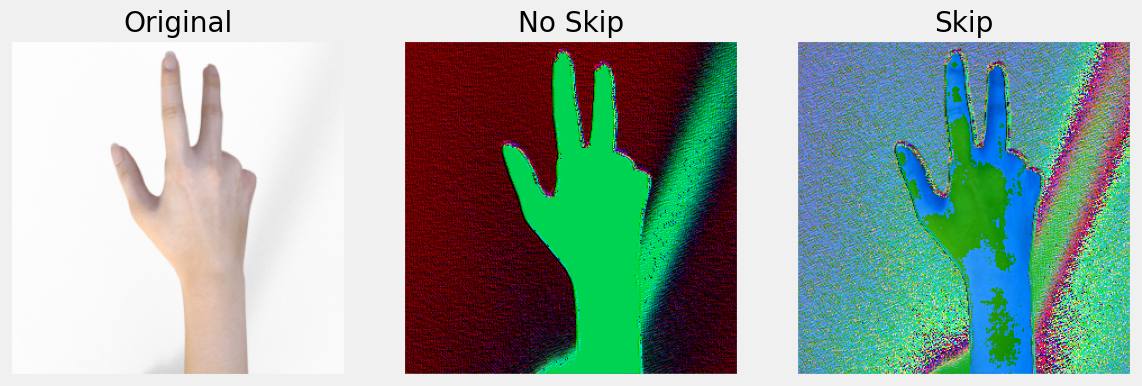

In [71]:
fig = compare_skip(scissors, noskip_image, skip_image)

# Putting It All Together

In [72]:
# ImageNet statistics
normalizer = Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])

composer = Compose([Resize(256),
                    CenterCrop(224),
                    ToTensor(),
                    normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

## Fine-tuning

In [73]:
# repeating import from the top for reference
from torchvision.models.resnet import ResNet18_Weights

# UPDATED
###########################################################
# This is the recommended way of loading a pretrained
# model's weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)
# model = resnet18(pretrained=True)
###########################################################

torch.manual_seed(42)
model.fc = nn.Linear(512, 3)

In [74]:
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_model = optim.Adam(model.parameters(), lr=3e-4)
sbs_transfer = StepByStep(model, multi_loss_fn, optimizer_model)

In [75]:
sbs_transfer.set_loaders(train_loader, val_loader)
sbs_transfer.train(1)

In [76]:
StepByStep.loader_apply(val_loader, sbs_transfer.correct)

tensor([[124, 124],
        [124, 124],
        [124, 124]])

## Feature Extraction

In [77]:
# repeating import from the top for reference
from torchvision.models.resnet import ResNet18_Weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# UPDATED
###########################################################
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
# model = resnet18(pretrained=True).to(device)
###########################################################

model.fc = nn.Identity()
freeze_model(model)

In [78]:
train_preproc = preprocessed_dataset(model, train_loader)
val_preproc = preprocessed_dataset(model, val_loader)
train_preproc_loader = DataLoader(train_preproc, batch_size=16, shuffle=True)
val_preproc_loader = DataLoader(val_preproc, batch_size=16)

In [79]:
torch.manual_seed(42)
top_model = nn.Sequential(nn.Linear(512, 3))
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_top = optim.Adam(top_model.parameters(), lr=3e-4)

In [80]:
sbs_top = StepByStep(top_model, multi_loss_fn, optimizer_top)
sbs_top.set_loaders(train_preproc_loader, val_preproc_loader)
sbs_top.train(10)

In [81]:
StepByStep.loader_apply(val_preproc_loader, sbs_top.correct)

tensor([[ 98, 124],
        [124, 124],
        [104, 124]])

In [82]:
model.fc = top_model
sbs_temp = StepByStep(model, None, None)

In [83]:
StepByStep.loader_apply(val_loader, sbs_temp.correct)

tensor([[ 98, 124],
        [124, 124],
        [104, 124]])